In [188]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [189]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12909689981408216486
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14055112704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14611036222615008270
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

# Step 1. 데이터 수집하기

In [190]:
data = pd.read_csv('./data/transformer_chatbot/ChatbotData.csv')
display(data.head())
print('데이터셋 개수: ',len(data))

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


데이터셋 개수:  11823


# Step 2. 데이터 전처리하기

In [191]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (한글, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

data['Q'] = data['Q'].apply(lambda x:  '<sos> '+ preprocess_sentence(x) + ' <eos>')
data['A'] = data['A'].apply(lambda x: '<sos> ' + preprocess_sentence(x) + ' <eos>')
data.head()

,Q,A,label
0,<sos> 시 땡 ! <eos>,<sos> 하루가 또 가네요 . <eos>,0
1,<sos> 지망 학교 떨어졌어 <eos>,<sos> 위로해 드립니다 . <eos>,0
2,<sos> 박 일 놀러가고 싶다 <eos>,<sos> 여행은 언제나 좋죠 . <eos>,0
3,<sos> 박 일 정도 놀러가고 싶다 <eos>,<sos> 여행은 언제나 좋죠 . <eos>,0
4,<sos> 심하네 <eos>,<sos> 눈살이 찌푸려지죠 . <eos>,0


In [192]:
questions, answers = list(data['Q']), list(data['A'])

In [193]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: <sos> 가스비 장난 아님 <eos>
전처리 후의 22번째 답변 샘플: <sos> 다음 달에는 더 절약해봐요 . <eos>


# Step 3. SubwordTextEncoder 사용하기

tensorflow-gpu와 tensorflow-datasets의 호환이 잘 안맞아서 keras.preprocessing.text의 Toknizer를 사용했다.

## 문장 길이 정하기

질문의 최소 길이 : 13
질문의 최대 길이 : 69
질문의 평균 길이 : 25.17043051678931
대답의 최소 길이 : 13
대답의 최대 길이 : 90
대답의 평균 길이 : 28.026135498604415


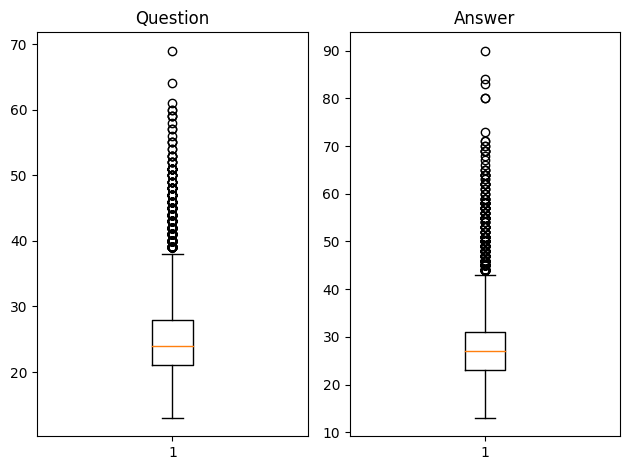

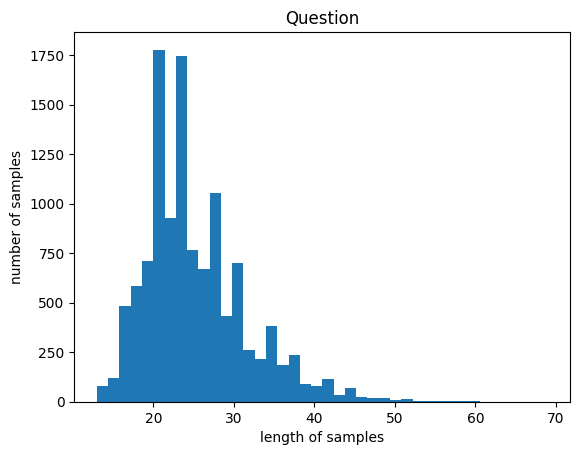

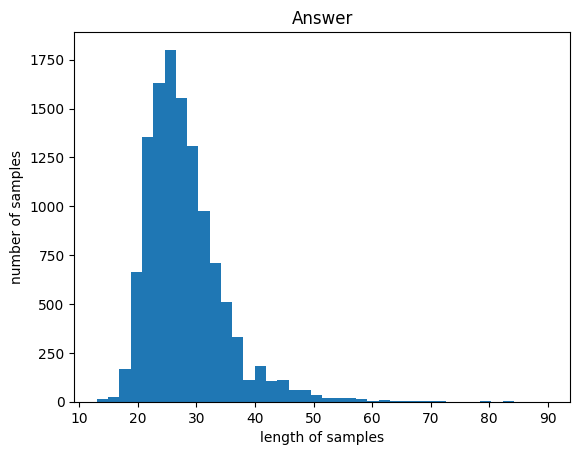

In [194]:
q_len = [len(s) for s in questions]
a_len = [len(s) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('대답의 최소 길이 : {}'.format(np.min(a_len)))
print('대답의 최대 길이 : {}'.format(np.max(a_len)))
print('대답의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(q_len)
plt.title('Question')
plt.subplot(1,2,2)
plt.boxplot(a_len)
plt.title('Answer')
plt.tight_layout()
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 질문의 평균 길이가 25.2 이고 최대길이가 69 이므로 40 정도로 설정
* 대답의 평균길이가 28 이고 최대길이가 90 이므로 60 정도로 설정

In [195]:
q_max_len = 40
a_max_len = 40

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(q_max_len, questions)
below_threshold_len(a_max_len,  answers)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9725112069694662
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9514505624629959


In [196]:
print('길이 전처리 전 전체 샘플수 :', (len(data)))
data = data[data['Q'].apply(lambda x: len(x) <= q_max_len)]
data = data[data['A'].apply(lambda x: len(x) <= a_max_len)]
print('길이 전처리 후 전체 샘플수 :', (len(data)))
questions, answers = list(data['Q']), list(data['A'])
data.head()

길이 전처리 전 전체 샘플수 : 11823
길이 전처리 후 전체 샘플수 : 10957


,Q,A,label
0,<sos> 시 땡 ! <eos>,<sos> 하루가 또 가네요 . <eos>,0
1,<sos> 지망 학교 떨어졌어 <eos>,<sos> 위로해 드립니다 . <eos>,0
2,<sos> 박 일 놀러가고 싶다 <eos>,<sos> 여행은 언제나 좋죠 . <eos>,0
3,<sos> 박 일 정도 놀러가고 싶다 <eos>,<sos> 여행은 언제나 좋죠 . <eos>,0
4,<sos> 심하네 <eos>,<sos> 눈살이 찌푸려지죠 . <eos>,0


## 인코딩 및 패딩

In [197]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions+answers)

In [198]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18843
등장 빈도가 1번 이하인 희귀 단어의 수: 10174
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8669
단어 집합에서 희귀 단어의 비율: 53.993525447115644
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.545989080218396


희귀 단어의 threshold는 2가 적당해 보인다. 따라서 희귀단어를 제외시킬 경우의 단어 집합의 크기를 따라 vocab_size를 8669로 정해주겠다.

vocabsize 전처리 참고: https://github.com/keras-team/keras/issues/8092

In [199]:
# 시작 토큰, 종료 토큰 고려, + 2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = 8669 + 2
tokenizer = Tokenizer( num_words=VOCAB_SIZE+1) # 단어 집합의 크기를 10003으로 제한 (패딩 고려 ?)
tokenizer.fit_on_texts(questions+answers) # 단어 집합 재생성

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  # 정수 인코딩
  sentence1 = tokenizer.texts_to_sequences(inputs)
  sentence2 = tokenizer.texts_to_sequences(outputs)
  
  # 질문, 대답의 최대길이로 padding
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      sentence1, maxlen=q_max_len, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      sentence2, maxlen=a_max_len, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)

In [200]:
    sorted_by_word_count = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
    tokenizer.word_index = {}
    i = 0
    for word,count in sorted_by_word_count:
        if i == VOCAB_SIZE:
            break
        tokenizer.word_index[word] = i + 1    # <= because tokenizer is 1 indexed
        i += 1

In [207]:
for i in range(1,15):
    print(tokenizer.index_word[i])

sos
eos
거예요
너무
수
더
잘
거
좋아하는
많이
것
안
좋은
좀


In [208]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8672
필터링 후의 질문 샘플 개수: 10957
필터링 후의 답변 샘플 개수: 10957


In [209]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Step 4. 모델 구성하기

## utils

In [210]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [211]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [212]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [213]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [214]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [215]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [216]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [217]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [218]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [219]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## model

In [220]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [221]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    13907968    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [222]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [223]:
EPOCHS = 100
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [224]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[es], batch_size=BATCH_SIZE)

Epoch 1/200
172/172 [==============================] - 18s 53ms/step - loss: 0.8272 - accuracy: 0.0222
Epoch 2/200
172/172 [==============================] - 9s 52ms/step - loss: 0.7023 - accuracy: 0.0256
Epoch 3/200
172/172 [==============================] - 9s 52ms/step - loss: 0.6486 - accuracy: 0.0256
Epoch 4/200
172/172 [==============================] - 9s 52ms/step - loss: 0.6218 - accuracy: 0.0255
Epoch 5/200
172/172 [==============================] - 9s 53ms/step - loss: 0.6015 - accuracy: 0.0267
Epoch 6/200
172/172 [==============================] - 9s 54ms/step - loss: 0.5826 - accuracy: 0.0283
Epoch 7/200
172/172 [==============================] - 9s 54ms/step - loss: 0.5601 - accuracy: 0.0300
Epoch 8/200
172/172 [==============================] - 9s 54ms/step - loss: 0.5340 - accuracy: 0.0315
Epoch 9/200
172/172 [==============================] - 9s 53ms/step - loss: 0.5029 - accuracy: 0.0332
Epoch 10/200
172/172 [==============================] - 9s 53ms/step - loss: 0.46

# Step 5. 모델 평가하기

In [425]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.transpose(tf.convert_to_tensor([[tokenizer.word_index['sos']]] + tokenizer.texts_to_sequences(preprocess_sentence(sentence).split())+ [[tokenizer.word_index['eos']]]))

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims([tokenizer.word_index['sos']], 0)

  # 디코더의 인퍼런스 단계
  for i in range(a_max_len):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, tokenizer.word_index['eos']):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
  return tf.squeeze(output_sequence, axis=0)

In [430]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.sequences_to_texts([[i.numpy()] for i in prediction if i < VOCAB_SIZE])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(''.join(predicted_sentence[1:])))

  # return predicted_sentence

개선점: 한국어 처리 시 형태소 분석기 사용, 사전에 없는 말 처리(encode 시 [[1],[],[3]] 이렇게 됌)

In [431]:
sentence_generation('이름이 뭐야')

입력 : 이름이 뭐야
출력 : 위로봇이요


In [432]:
sentence_generation('나이가 뭐야')

입력 : 나이가 뭐야
출력 : 나이는숫자일뿐이예요


In [433]:
sentence_generation('나는 커서 뭐가 될까')

입력 : 나는 커서 뭐가 될까
출력 : 미련을할거같아요


In [434]:
sentence_generation('돈 벌고 싶어')

입력 : 돈 벌고 싶어
출력 : 저도요


In [435]:
sentence_generation('연애는 어떻게 하는 거지')

입력 : 연애는 어떻게 하는 거지
출력 : 사랑은정말사랑은미련이해요
